# Meta parameters

__Parameters__ - features of the model that are learned by algorithm (weights between the nodes). It is not set by us.

__Metaparameters__ - features of model set by us. Not learned by the model.

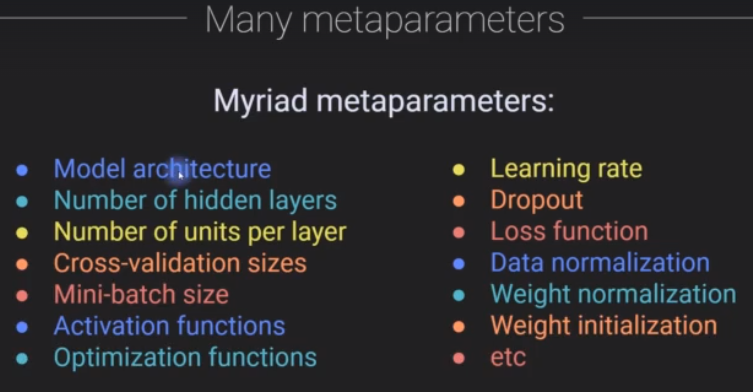

## Wine quality dataset

Measure various chemical properties of wine and predict how good it is.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

Likely target variable - "quality" with values ranging from 3-8

In [3]:
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [4]:
# listing number of unique values per column

for i in data.keys():
    print(i, f'- {len(np.unique(data[i]))} unique values')

fixed acidity - 96 unique values
volatile acidity - 143 unique values
citric acid - 80 unique values
residual sugar - 91 unique values
chlorides - 153 unique values
free sulfur dioxide - 60 unique values
total sulfur dioxide - 144 unique values
density - 436 unique values
pH - 89 unique values
sulphates - 96 unique values
alcohol - 65 unique values
quality - 6 unique values


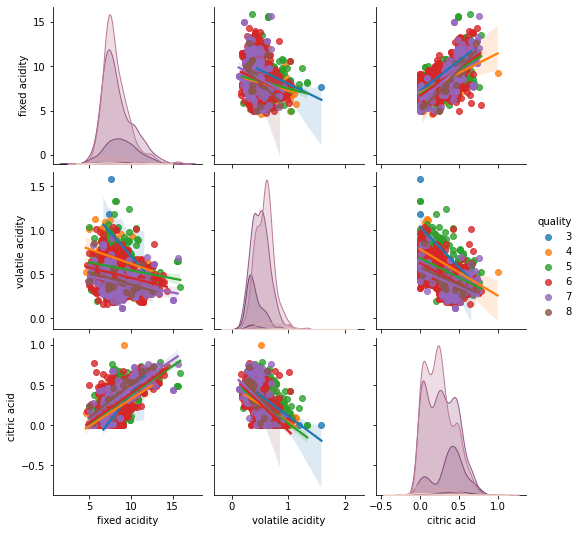

In [5]:
# pairwise plots
cols2plot = ['fixed acidity','volatile acidity','citric acid','quality']
sns.pairplot(data[cols2plot],kind='reg',hue='quality')
plt.show()

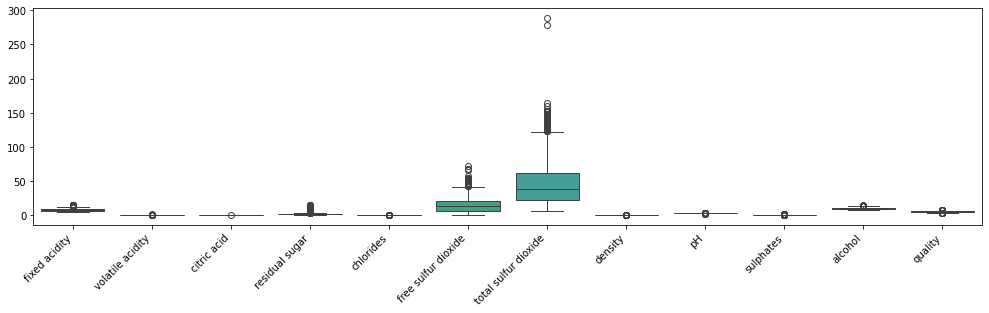

In [6]:
# plot some data
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.xticks(rotation=45, ha="right")  # Set x-axis tick label rotation and alignment
plt.show()

We have outliers in rows of 'total sulfur dioxide'

In [7]:
# removing rows with outliers

data = data[data['total sulfur dioxide'] < 200]

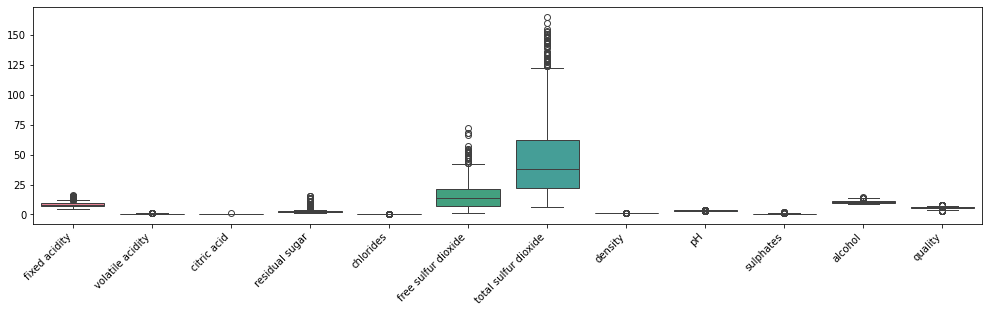

In [8]:
# plot some data
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.xticks(rotation=45, ha="right")  # Set x-axis tick label rotation and alignment
plt.show()

Since rows have huge ranges, we can use z-score to normalize on all variables except target variable 'quality'

In [9]:
# z-score

zscoreCols = data.keys().drop('quality')

for i in zscoreCols:
    mean = np.mean(data[i])
    stdev = np.std(data[i], ddof=1)
    data[i] = (data[i] - mean)/stdev

# can also be done using the line below
# data[zscoreCols] = data[zscoreCols].apply(stats.zscore)

data.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.597000e+03      1.597000e+03  1.597000e+03    1.597000e+03   
mean    1.779694e-17      1.156801e-16  1.779694e-17   -7.563699e-17   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.135419e+00     -2.280048e+00 -1.391387e+00   -1.168783e+00   
25%    -7.003882e-01     -7.715838e-01 -9.283861e-01   -4.524372e-01   
50%    -2.411785e-01     -4.528645e-02 -5.382836e-02   -2.375335e-01   
75%     5.050372e-01      6.251419e-01  7.692848e-01    4.900487e-02   
max     4.350918e+00      5.876831e+00  3.753070e+00    9.289866e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.597000e+03         1.597000e+03          1.597000e+03  1.597000e+03   
mean  -1.512740e-16        -1.779694e-17         -7.118775e-17 -8.357442e-14   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.604073e+00        -1.422392e+00         -1.262186e+00 -3.545821e+00   
25%   -3.720247e-01        -8.476045e-01         -7.594598e-01 -6.109478e-01   
50%   -1.808448e-01        -1.770192e-01         -2.567340e-01 -6.214425e-04   
75%    5.281955e-02         4.935662e-01          4.973546e-01  5.778618e-01   
max    1.112001e+01         5.379259e+00          3.733652e+00  3.682565e+00   

                 pH     sulphates       alcohol      quality  
count  1.597000e+03  1.597000e+03  1.597000e+03  1597.000000  
mean   3.025479e-16  8.008622e-17 -5.872989e-16     5.634314  
std    1.000000e+00  1.000000e+00  1.000000e+00     0.806630  
min   -3.708218e+00 -1.936711e+00 -1.898626e+00     3.000000  
25%   -6.585382e-01 -6.390204e-01 -8.650444e-01     5.000000  
50%   -9.670044e-03 -2.261189e-01 -2.073106e-01     6.000000  
75%    5.743113e-01  4.227263e-01  6.383472e-01     6.000000  
max    4.532407e+00  7.913939e+00  4.208902e+00     8.000000

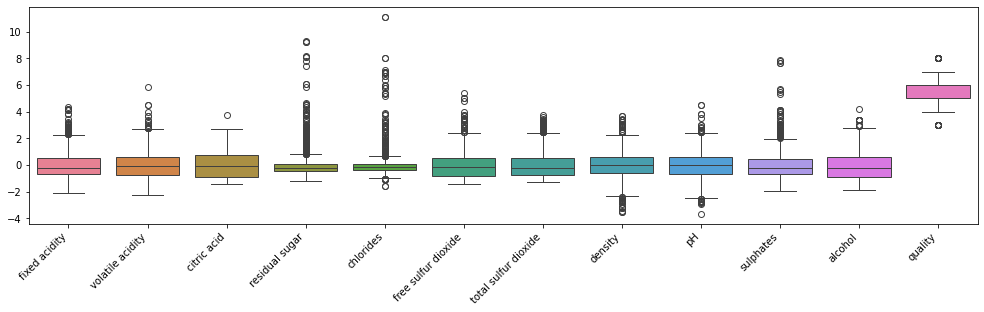

In [10]:
# plot some data
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.xticks(rotation=45, ha="right")  # Set x-axis tick label rotation and alignment
plt.show()

We have to check the data distribution of 'quality' and see how they are represented. This helps us understand the kind of distribution each class holds.

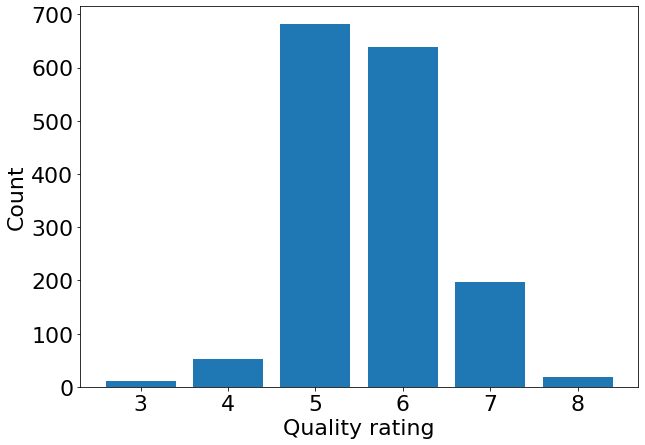

In [11]:
# distribution quality values
fig = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 22}) # increase font size in the figure

counts = data['quality'].value_counts()
plt.bar(list(counts.keys()),counts)
plt.xlabel('Quality rating')
plt.ylabel('Count')
plt.show()

There is a significant imbalance in the quality ratings which would affect the learnings of model. Hence we could binarize the quality by dividing into low and high qualities:

quality < 6 = 0, else 1

In [12]:
# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

data[['quality','boolQuality']]

quality  boolQuality
0           5            0
1           5            0
2           5            0
3           6            1
4           5            0
...       ...          ...
1594        5            0
1595        6            1
1596        6            1
1597        5            0
1598        6            1

[1597 rows x 2 columns]

Reorganize the data into features and labels, and then into tensors, train, test, loaders etc:

In [13]:
data_t = torch.tensor(data[zscoreCols].values).float()
labels = torch.tensor(data['boolQuality'].values).float()

print(data_t.shape, labels.shape)

# convert labels into a 1D tensor
labels = labels[:, None]
labels.shape

torch.Size([1597, 11]) torch.Size([1597])


torch.Size([1597, 1])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_t, labels, test_size=.2, shuffle=True)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 64

trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [15]:
for X, y in trainLoader:
    print(X.shape, y.shape)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


## Normalization

When magnitude is large, losses will also be huge which also affects the change in weights, and hence the process of learning for each feature will be different and overall inefficient.

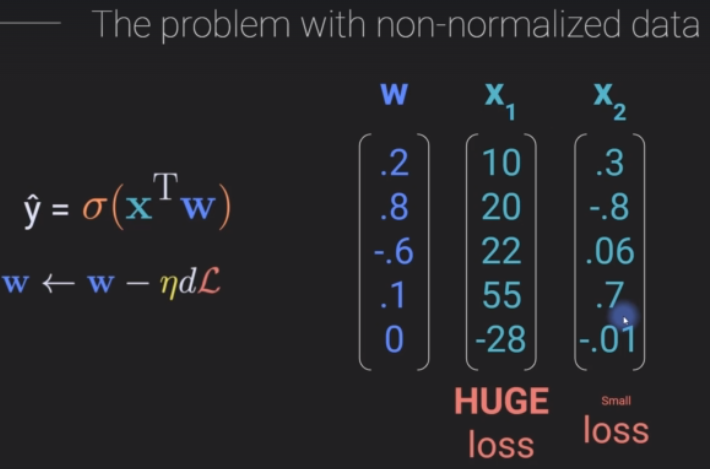

Normalization ensures that all data features are treated the same, and weights remain numerically stable.

- __Z-score__ - makes sure all features are in same range. It shifts and stretches but doesn't change shape
$$z_i = \frac{x_i - \bar{x_i}}{\sigma_x}$$

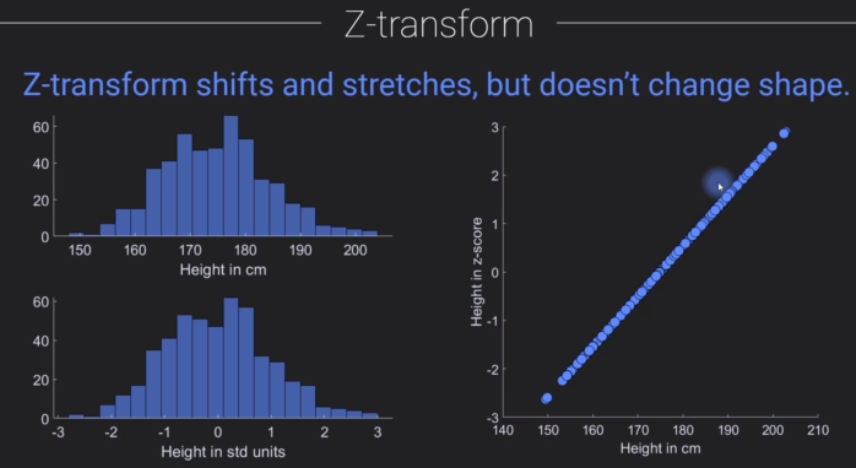



- __Min-max scaling__ - ensures data is between 0 and 1.
$$\tilde{x} = \frac{x - \min{x}}{\max{x} - \min{x}}$$

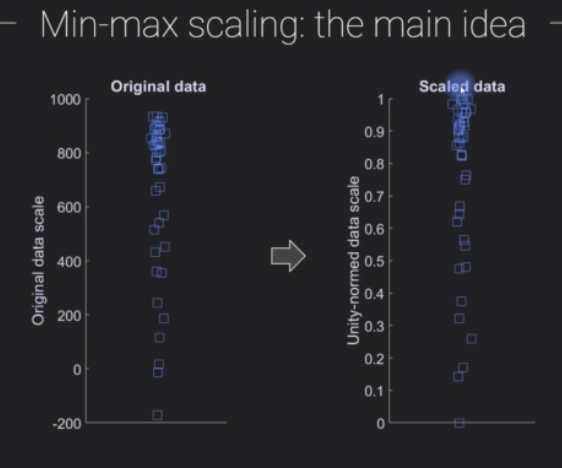


We can also rescale the data between __a__ to __b__ by $x^* = a + \tilde{x}(b - a)$

Min-Max scaling is common for uniform data and images.  
Z-scoring is common for data that are normally distributed or skewed or clustered.

## Batch Normalisation

Idea is to normalize not just raw input, but also the inputs going into each layer of NN.

Activation functions applied on output of each layer also affects the mean and other charactersitics of the data at that point. Hence, we cannot keep normalizing with the same mean and other charactersitcs of the input to the output of each layer. So, the better idea is to make mean and std as learnable parameters of NN.

Idea is to scale the raw input to $\gamma$ and shift it by $\beta$ as shown below:

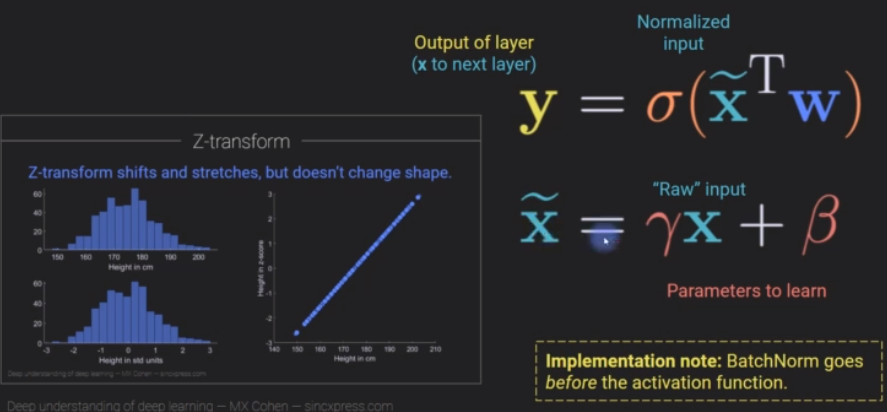

$\gamma$ is the learnable standard deviation and $\beta$ is the learnable mean parameter (because during normalization, we shift the data by mean and divide by standard deviation). So, now, $\tilde{x}$ is the input to the activation.

There are various opinions and research whether to normalize the data first and send it to activation, or send it to activation first and then normalize the data.

__Batch Normalization is applied only during training.__ It should be turned off for validation and testing data as it is applied on batches, and batch size could differ in val and test. It is automatically switched off with eval() mode in pytorch.

It is more useful for deep nets. It acts as a form of regularization. It is more suitable to call it as __layer normalization__.

### Implementation in Pytorch

In [16]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:,None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader,  testLoader

In [17]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
trainLoader, testLoader = load_data(data, labels)

In [18]:
# NN with Batch Normalization

class ANN_BNorm(nn.Module):
    def __init__(self):
        super().__init__()

        self.ip = nn.Linear(11, 16)   # ip layer
        self.bn1 = nn.BatchNorm1d(16)  # number of units that go into this layer
        self.h1 = nn.Linear(16, 32)   # hidden layer 1
        self.bn2 = nn.BatchNorm1d(32)  # number of units that go into this layer 
        self.h2 = nn.Linear(32, 20)  # hidden layer 2
        self.op = nn.Linear(20, 1)
    
    def forward(self, x, doBN):  # doBN is bool set to true for train, and false for test
        
        x = F.relu(self.ip(x))
        
        if doBN:
            x = self.bn1(x)
        
        x = F.relu(self.h1(x))
            
        if doBN:
            x = self.bn2(x)
        
        x = F.relu(self.h2(x))
        
#         else:
#             x = F.relu(self.h1(x))
#             x = F.relu(self.h2(x))
        
        return self.op(x)

In [19]:
# training the model

nEp = 1000

def trainModel(wine_net, doBN=True):
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(wine_net.parameters(), lr = 0.01)
    
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        
        wine_net.train()
        
        batchLoss, batchAcc = [], []
        
        for x, y in trainLoader:
            
            yHat = wine_net(x, doBN)
            loss = lossfn(yHat, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        wine_net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = wine_net(x, doBN)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
          
    
    return trainAcc, testAcc, losses

In [20]:
wine_net = ANN_BNorm()
trainAccNA, testAccNA, lossesNA = trainModel(wine_net, False) # without batch norm

wine_net = ANN_BNorm()
trainAcc, testAcc, losses = trainModel(wine_net, True) # without batch norm

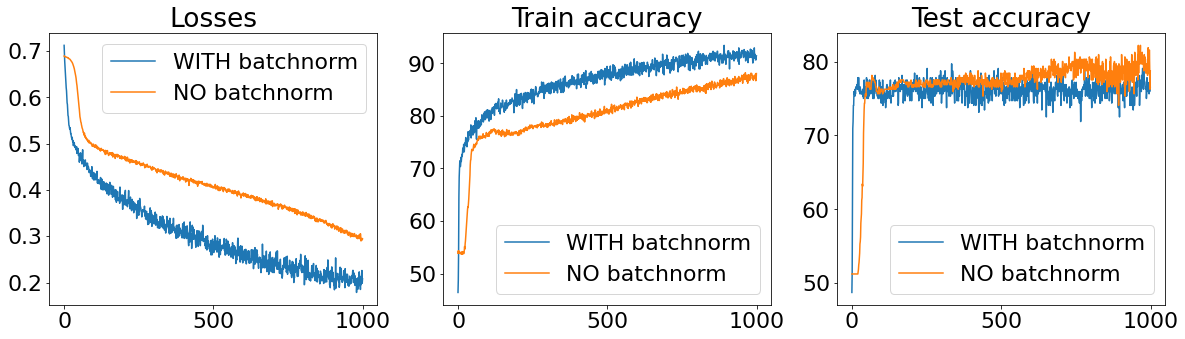

In [21]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(20,5))

ax[0].plot(losses,label='WITH batchnorm')
ax[0].plot(lossesNA,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAcc,label='WITH batchnorm')
ax[1].plot(trainAccNA,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAcc,label='WITH batchnorm')
ax[2].plot(testAccNA,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

## Activation Functions

Some desirable quailities for activation functions :

- __For a hidden layer__ - non-linearity, computationally simple, avoiding limited range and vanishing/exploding gradient problem.
- __For an output layer__ - non-linear for classification, or linear for regression. Should be able to saturating in a range (say [0,1])  for converting to probabilities.

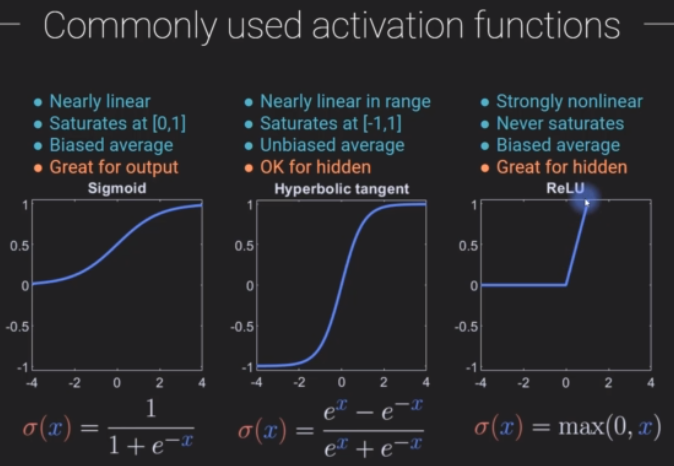

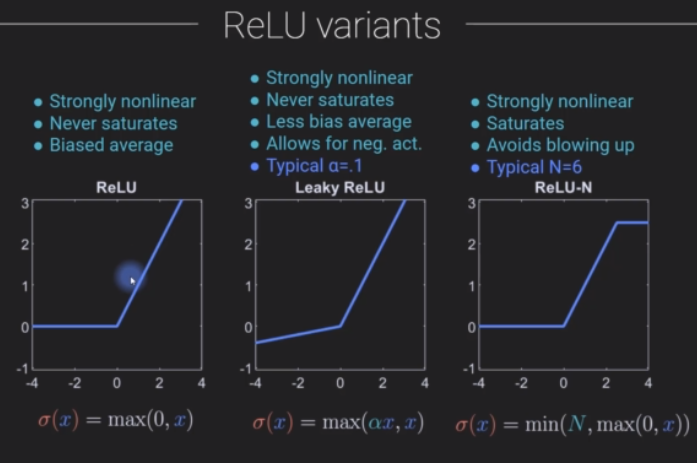

### Activation functions in practice

In [22]:
# import libraries
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

In [23]:
x = torch.linspace(-3, 3, 101) # creating data

def NNop(actFn):
    actFn = getattr(torch, actFn)
    return actFn(x)

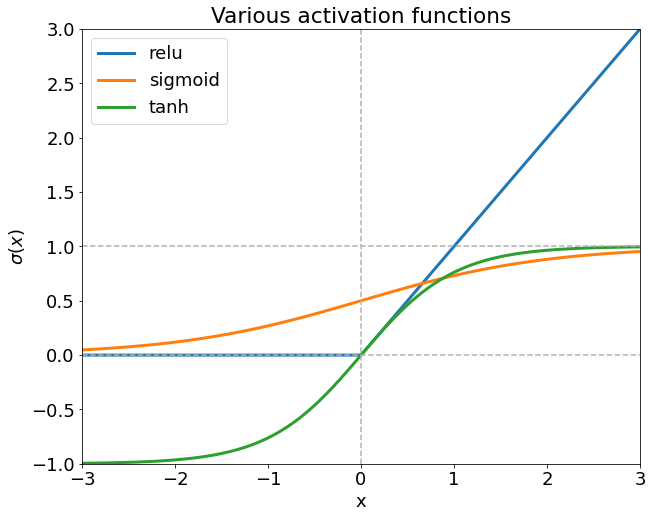

In [24]:
af  = ['relu', 'sigmoid', 'tanh']

fig = plt.figure(figsize=(10,8))

for i in af:
    plt.plot(x,NNop(i),label=i,linewidth=3)
    
# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
plt.show()

#### Activation functions in torch.nn

In [25]:
def NNop(actFn):
    actFn = getattr(torch.nn, actFn)
    return actFn()

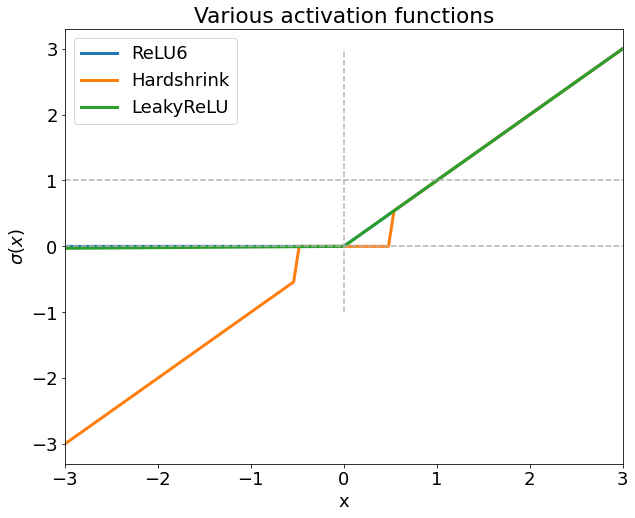

In [26]:
af = ['ReLU6', 'Hardshrink', 'LeakyReLU']

fig = plt.figure(figsize=(10,8))

for actfun in af:
  plt.plot(x,NNop(actfun)(x),label=actfun,linewidth=3)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
# plt.ylim([-1,3])
# plt.ylim([-.1,.1])
plt.show()

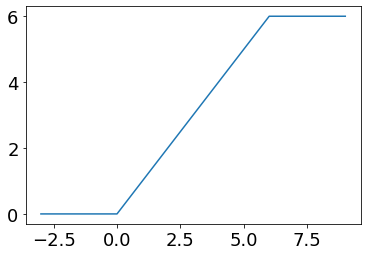

In [27]:
# relu6 in more detail
x = torch.linspace(-3,9,101)
relu6 = torch.nn.ReLU6()

plt.plot(x,relu6(x))
plt.show()

#### Difference in torch and torch.nn

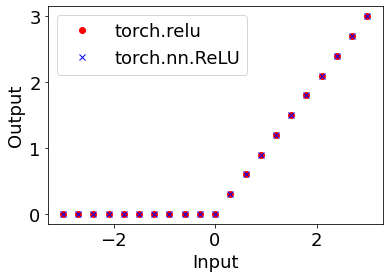

In [28]:
x = torch.linspace(-3,3,21)

y1 = torch.relu(x)

f = torch.nn.ReLU()
y2 = f(x)

# the results are the same
plt.plot(x,y1,'ro',label='torch.relu')
plt.plot(x,y2,'bx',label='torch.nn.ReLU')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

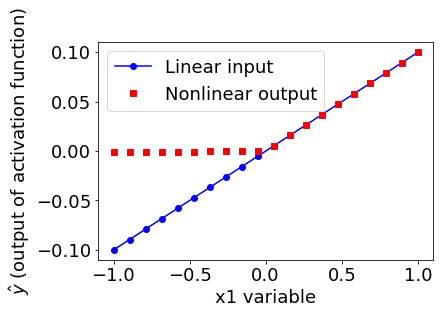

In [29]:
#  experimentation with different activation functions

x1 = torch.linspace(-1,1,20)
x2 = 2*x1

w1, w2 = -.1, .1

lin = w1*x1 + w2*x2 # linear combination

y = torch.nn.LeakyReLU()(lin)

# and plot!
plt.plot(x1,lin,'bo-',label='Linear input')
plt.plot(x1,y,'rs',label='Nonlinear output')
plt.ylabel('$\\hat{y}$ (output of activation function)')
plt.xlabel('x1 variable')
# plt.ylim([-.1,.1]) # optional -- uncomment and modify to zoom in
plt.legend()
plt.show()

### Activation functions comparision on wine dataset

In [30]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:,None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader,  testLoader

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
trainLoader, testLoader = load_data(data, labels)

In [31]:
# NN with Batch Normalization

class ANN_BNorm(nn.Module):
    def __init__(self, actfn):
        super().__init__()

        self.ip = nn.Linear(11, 16)   # ip layer
        self.bn1 = nn.BatchNorm1d(16)  # number of units that go into this layer
        self.h1 = nn.Linear(16, 32)   # hidden layer 1
        self.bn2 = nn.BatchNorm1d(32)  # number of units that go into this layer 
        self.h2 = nn.Linear(32, 20)  # hidden layer 2
        self.op = nn.Linear(20, 1)
        self.actfn = actfn
    
    def forward(self, x, doBN=True):  # doBN is bool set to true for train, and false for test
        
        actfn = getattr(torch, self.actfn)
        
        x = actfn(self.ip(x))
        
        if doBN:
            x = self.bn1(x)
        
        x = actfn(self.h1(x))
            
        if doBN:
            x = self.bn2(x)
        
        x = actfn(self.h2(x))
        
        return self.op(x)

In [32]:
# testing the model

net = ANN_BNorm('sigmoid')
net(torch.randn(10, 11)).shape

torch.Size([10, 1])

In [33]:
# training the model

nEp = 1000

def trainModel(wine_net, doBN=True):
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(wine_net.parameters(), lr = 0.01)
    
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        
        wine_net.train()
        
        batchLoss, batchAcc = [], []
        
        for x, y in trainLoader:
            
            yHat = wine_net(x, doBN)
            loss = lossfn(yHat, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        wine_net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = wine_net(x, doBN)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
          
    
    return trainAcc, testAcc, losses

In [34]:
af = ['relu', 'tanh', 'sigmoid']

trAct = np.zeros((nEp, len(af)))
teAct = np.zeros((nEp, len(af)))

for i, AFn in enumerate(af):
    net = ANN_BNorm(AFn)
    trAct[:, i], teAct[:, i], losses = trainModel(net)

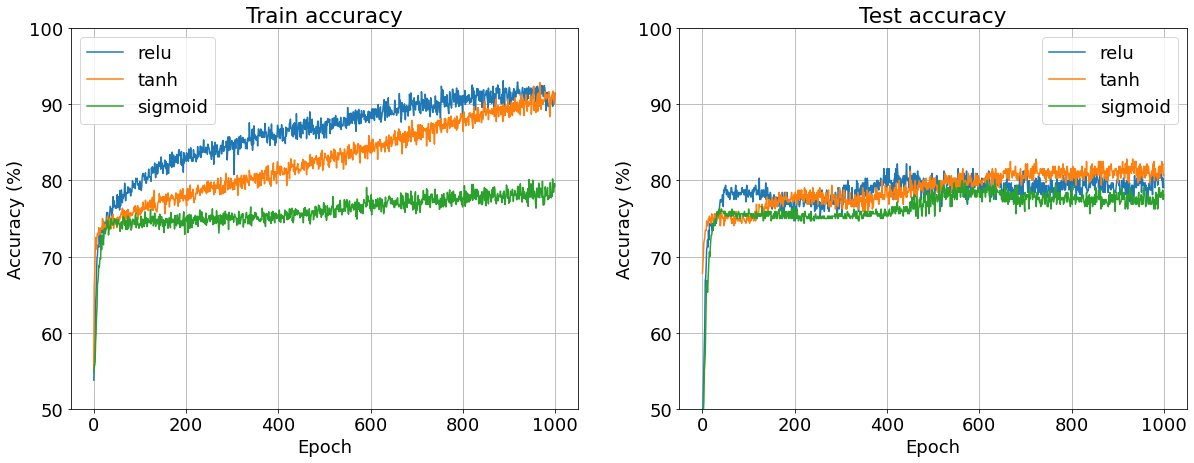

In [35]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trAct)
ax[0].set_title('Train accuracy')
ax[1].plot(teAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(af)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

# Loss functions

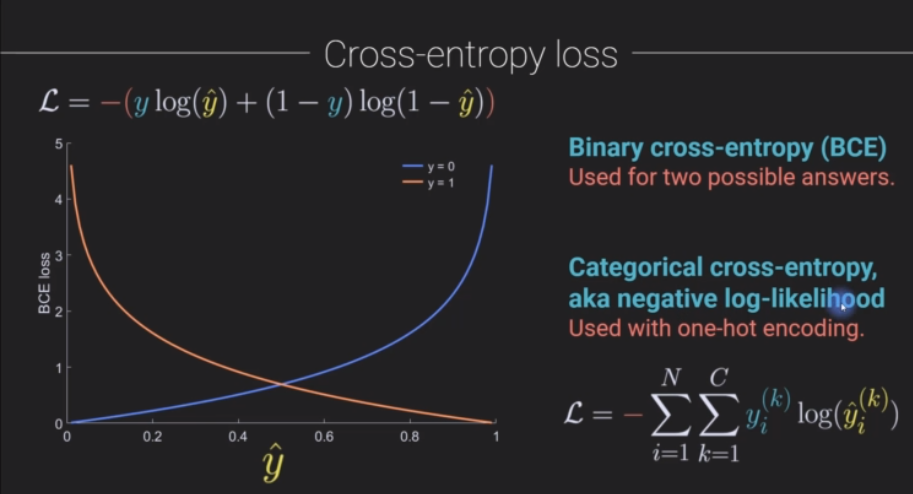

KL distance (Kullback-Leiber divergence) - Measures the distance between two probability distributions:
$$L = \sum_xp(x)\log\left(\frac{p(x)}{q(x)}\right)$$

### Output Layer architectures

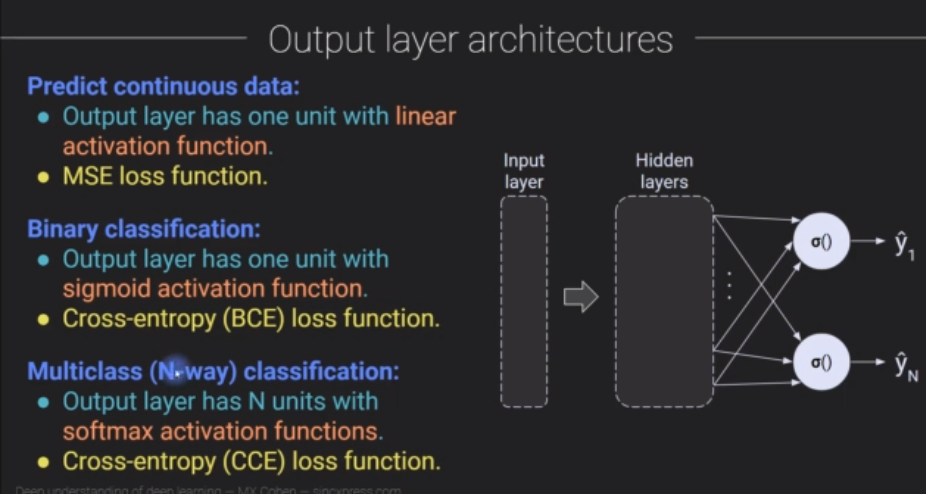


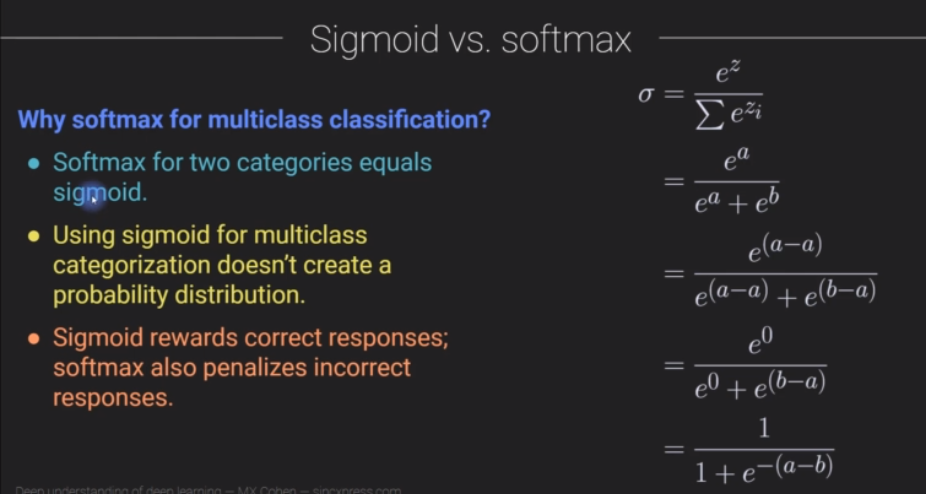

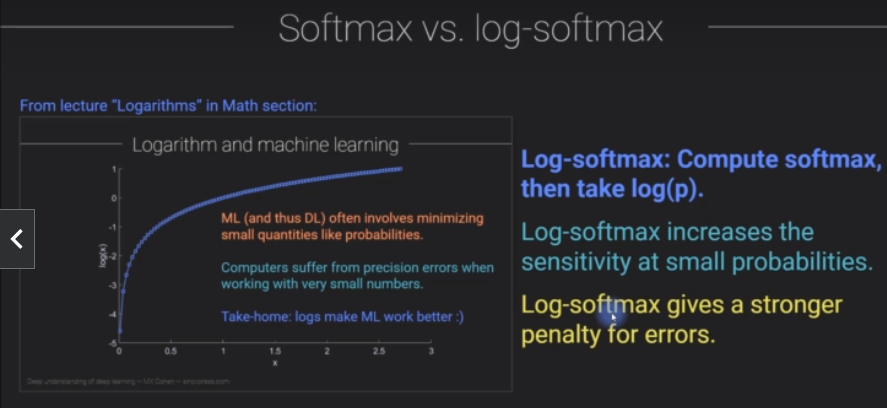

Their implementation in pytorch:

### MSE Loss

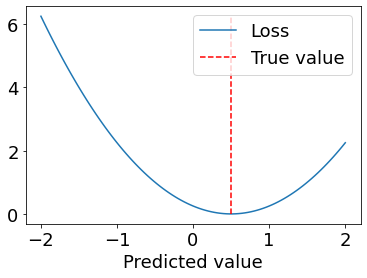

In [36]:
# MSE

lMSE = nn.MSELoss()

# using on data
yH = torch.linspace(2, -2, 101)
y = torch.tensor(.5) # ground truth

# computing MSE
L = np.zeros(101)
for i, j in enumerate(yH):
    L[i] = lMSE(j,y)

plt.plot(yH,L,label='Loss')
plt.plot([y,y],[0,np.max(L)],'r--',label='True value')
plt.xlabel('Predicted value')
plt.legend()
plt.show()

### BCE Loss

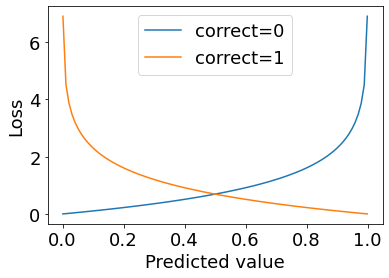

In [37]:
lBCE = nn.BCELoss()

yH = torch.linspace(.001, .999, 101)
y1 = torch.tensor(0.) 
y2 = torch.tensor(1.)

L = np.zeros((101,2))
for i, j in enumerate(yH):
    L[i, 0] = lBCE(j, y1)
    L[i, 1] = lBCE(j, y2)

plt.plot(yH,L)
plt.xlabel('Predicted value')
plt.ylabel('Loss')
plt.legend(['correct=0','correct=1'])
# plt.yscale('log')
plt.show()

In [38]:
# sigmoid converts the values between 0-1
# using BCE loss on op not in 0-1 without transforming using sigmoid

yH = torch.tensor(2.)
# print(lBCE(yH, y2))

# now converting it into sigmoid
print(lBCE(nn.Sigmoid()(yH), y2))

# using BCEWithLogits loss instead
print(nn.BCEWithLogitsLoss()(yH, y2))

tensor(0.1269)
tensor(0.1269)


### Categorical Cross entropy (CCE) loss

In [39]:
lCE = nn.CrossEntropyLoss()

yH = torch.tensor([[1., 4, 3]]) # vector of op before softmax

for i in range(3):
    ans = torch.tensor([i]) # ground truth
    l = lCE(yH, ans).item()
    print('Loss when correct answer is %g : %g' %(i, l))
  
print('----------------------------------')

# repeating using softmaxed op - NOT CORRECT as CE loss also computes softmax of the outpts
sm = nn.Softmax(dim=1)
yHsm = sm(yH)

for i in range(3):
    ans = torch.tensor([i])
    thisloss = lCE(yHsm,ans).item()
    print( 'Loss when correct answer is %g: %g' %(i,thisloss))

Loss when correct answer is 0 : 3.34901
Loss when correct answer is 1 : 0.349012
Loss when correct answer is 2 : 1.34901
----------------------------------
Loss when correct answer is 0: 1.43658
Loss when correct answer is 1: 0.766318
Loss when correct answer is 2: 1.21221


In [40]:
# compare raw, softmax, and log-softmax outputs
sm = nn.LogSoftmax(dim=1)
yH_logsm = sm(yH)

# print them
print(yH)
print(yHsm)
print(yH_logsm)

tensor([[1., 4., 3.]])
tensor([[0.0351, 0.7054, 0.2595]])
tensor([[-3.3490, -0.3490, -1.3490]])


### Creating custom loss function

Same as creating a custom class for ANN

In [41]:
class myLoss(nn.Module): # inheriting from nn.Module
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y):  # order of parameters are important
        return torch.abs(x-y)

# testing it
lfn = myLoss()
lfn(torch.tensor(4.), torch.tensor(5.2))

tensor(1.2000)

## Practice with multioutput ANN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

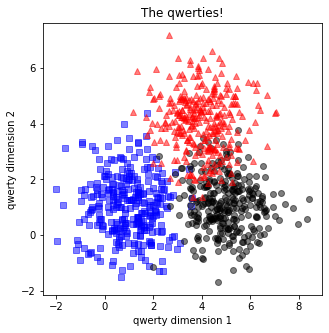

In [2]:
# create data

npc = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(npc)*blur , A[1]+np.random.randn(npc)*blur ]
b = [ B[0]+np.random.randn(npc)*blur , B[1]+np.random.randn(npc)*blur ]
c = [ C[0]+np.random.randn(npc)*blur , C[1]+np.random.randn(npc)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((npc)),
                         np.ones( (npc)),
                       1+np.ones( (npc))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

bs = 16
trainLoader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [37]:
print('Number of batches:', len(trainLoader))

Number of batches: 50


In [38]:
def createNet():
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(2, 8) # 2 ip
            self.h1 = nn.Linear(8, 8)
            self.op = nn.Linear(8, 3) # 3 op classes

        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            return self.op(x)
    
    net = qwertyNet()
    lossfn = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(net.parameters(), lr = .01)
    
    return net, lossfn, optim

The ReLU fn can also be written as :
``` ....
        self.ip = nn.Linear(2, 8) # 2 ip
        self.relu1 = nn.ReLU()
        ...
```

and can be used in ```forward()``` method as:
```
    .....
    x = self.relu1(self.ip(x)) 
    .....
```

In [39]:
# # testing the model

# ip = torch.rand(10, 2)
# net, _ , _ = createNet()
# net(ip) # should output (10,3) samples

In [40]:
def trainModel():
    
    nEp = 100
    
    net, lossfn, optim = createNet()
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        batchAcc, batchLoss = [], []
        net.train()
        
        for X, y in trainLoader:
            op = net(X)
            loss = lossfn(op, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
        
            matches = torch.argmax(op, axis=1) == y
            matches_num = matches.float()
            acc = 100*torch.mean(matches_num)
            batchAcc.append(acc)
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            pred = net(x)
        testAcc.append(100*torch.mean((torch.argmax(pred, axis=1) == y).float()))
        
    return net, trainAcc, testAcc, losses

In [41]:
net, trainAcc, testAcc, losses = trainModel()

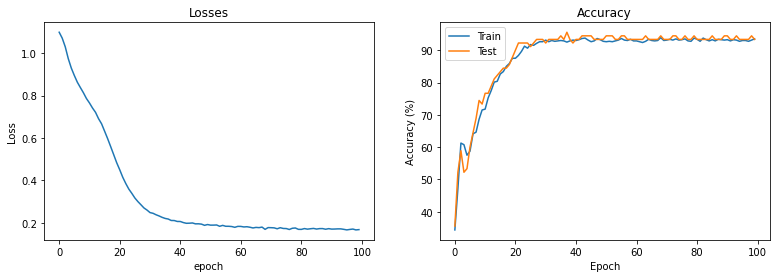

In [42]:
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

Looking at the results in categorical terms:

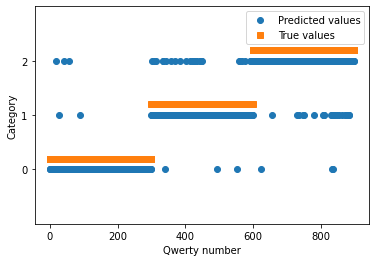

In [43]:
# run the data through the model to get the categorical predictions
yHat = net(data)
pred = torch.argmax(yHat,axis=1)

# and plot those against the real data
plt.plot(pred,'o',label='Predicted values')
plt.plot(labels+.2,'s',label='True values')
plt.xlabel('Qwerty number')
plt.ylabel('Category')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

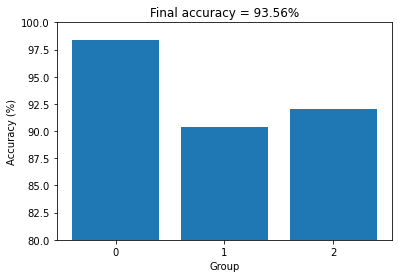

In [44]:
acc = (pred == labels).float()

totalAcc = torch.mean(100*acc).float()

accByGrp = np.zeros(3)
for i in range(3):
    accByGrp[i] = 100*torch.mean(acc[labels==i])

plt.bar(range(3),accByGrp)
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f'Final accuracy = {totalAcc:.2f}%')
plt.show()

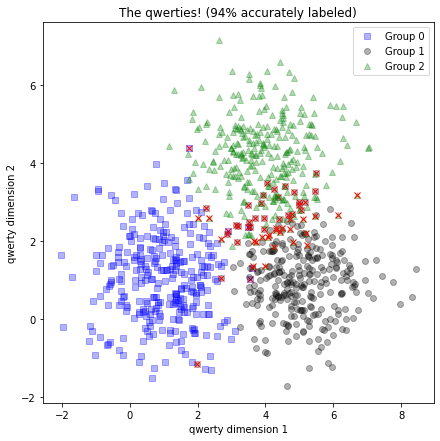

In [45]:
# Finally, show the qwerties in their native space, labeled by accuracy

# data markers
colorShapes = [ 'bs','ko','g^' ]


# show the data
fig = plt.figure(figsize=(7,7))

# plot correct and incorrect labeled data
for i in range(3):
  # plot all data points for this label
  plt.plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
  
  # cross out the incorrect ones
  idxErr = (acc==0) & (labels==i)
  plt.plot(data[idxErr,0],data[idxErr,1],'rx')

plt.title(f'The qwerties! ({totalAcc:.0f}% accurately labeled)')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

# Optimizers

Optimizers - Algorithms that __adjust the weights__ during backprop.

__Stochastic Gradient descent__ - Change weights after each sample. Great when the samples are similar to each other.
$$W \leftarrow W - \eta d L$$

__Mini-batch SGD__ - change weights after N samples. Average losses across N samples.

__Momentum__ - smoothing via weighted averaging. Each data point is weighted combination of itself and previous data point.
$$v_t = (1-\beta)v_t + \beta v_{t-1}, \beta \in \{0,1\}$$
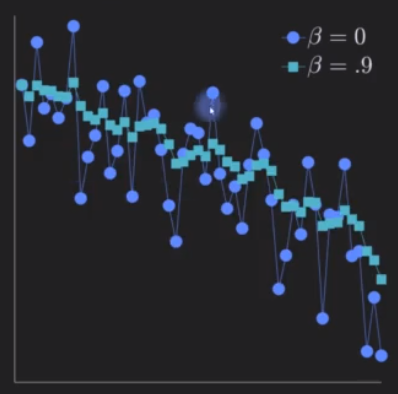

__SGD with momentum__ - Upgrade current weights acc to weighted avg of current and previous costs.

$$ v = (1-\beta)dJ + \beta v{t-1}$$

$$w = \leftarrow w - \eta v $$
$dJ$ is gradient of cost function. When $\beta$ is 0, it is just SGD. Typical values of $\beta$ are .9 to .99.

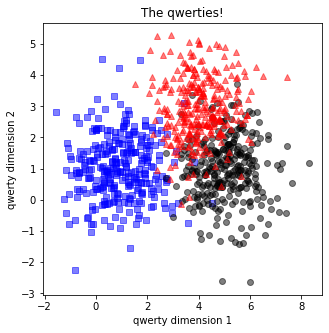

Number of batches: 50


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# create data

npc = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(npc)*blur , A[1]+np.random.randn(npc)*blur ]
b = [ B[0]+np.random.randn(npc)*blur , B[1]+np.random.randn(npc)*blur ]
c = [ C[0]+np.random.randn(npc)*blur , C[1]+np.random.randn(npc)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((npc)),
                         np.ones( (npc)),
                       1+np.ones( (npc))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

bs = 16
trainLoader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

print('Number of batches:', len(trainLoader))

In [7]:
# Momentum implementation in Pytorch
def createNet(momentum):
    
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(2, 8) # 2 ip
            self.h1 = nn.Linear(8, 8)
            self.op = nn.Linear(8, 3) # 3 op classes

        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            return self.op(x)
    
    net = qwertyNet()
    lossfn = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(net.parameters(), lr = .01, momentum=momentum) # adding momentum here
    
    return net, lossfn, optim

In [12]:
nEp = 50

def trainModel(momentum):
        
    net, lossfn, optim = createNet(momentum)
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        batchAcc, batchLoss = [], []
        net.train()
        
        for X, y in trainLoader:
            op = net(X)
            loss = lossfn(op, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
        
            matches = torch.argmax(op, axis=1) == y
            matches_num = matches.float()
            accPt = 100*torch.mean(matches_num)
            batchAcc.append(accPt)
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            pred = net(x)
        testAcc.append(100*torch.mean((torch.argmax(pred, axis=1) == y).float()))
        
    return net, trainAcc, testAcc, losses

In [15]:
momenta = [0, 0.5, 0.9, 0.95, 0.99]

res = np.zeros((nEp, len(momenta), 3))

for i, m in enumerate(momenta):
    net, trainAcc, testAcc, losses = trainModel(m)
    res[:, i, 2] = trainAcc
    res[:, i, 1] = testAcc
    res[:, i, 0] = losses

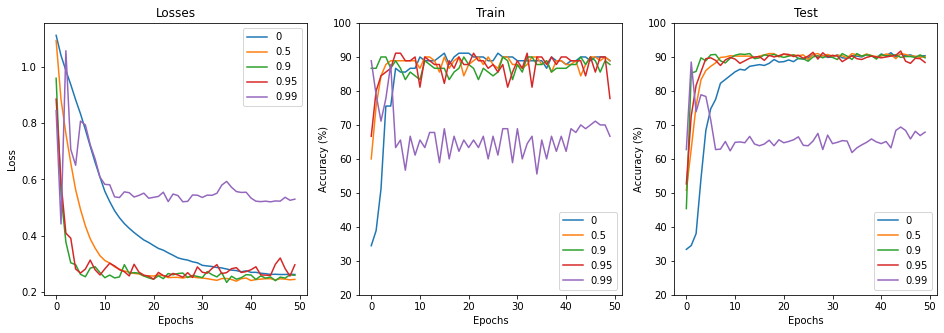

In [17]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
    ax[i].plot(res[:,:,i])
    ax[i].legend(momenta)
    ax[i].set_xlabel('Epochs')
    if i==0:
        ax[i].set_ylabel('Loss')
    else:
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

Having no momentum is not that great, having some momentum (.9 - .95) is good, having more momentum is pretty much useless.

### RMSprop

__RMSprop__ - Root Mean Square Propogation.Similar to momentum where weight changes using dampened previous gradients. However, Instead of biasing the gradient, __bias the learning rate__ according to magnitude of gradient.

RMS: Total Energy (of gradients)
$$\sqrt{\frac{1}{n}\sum^n_{i=1}x_i^2}$$

Standard deviation: Dispersion Energy 
$$\sqrt{\frac{1}{n}\sum^n_{i=1}(x_i^2 - \bar{x}_i^2)}$$

RMS is Std dev with 0 mean (centered data)

__RMSprop__:
$$s = (1-\beta)(dJ)^2 + \beta s_{t-1}$$

$$ w \leftarrow w - \frac{\eta}{\sqrt{s + \epsilon}}dJ$$

$\epsilon$ - small quantity added to $v$ to not make denominator 0.  
$dJ$ - derivative of cost function.  
$s$ - momentum

Key idea : Step size for adjusting the weights depends on history of gradient magnitudes. Larger gradients -> smaller step, and vice versa.

### Adam (Adaptive Momentum)

Idea - Combine Momentum and RMSProp (best of both worlds). __Currently the best optimizer in the field.__

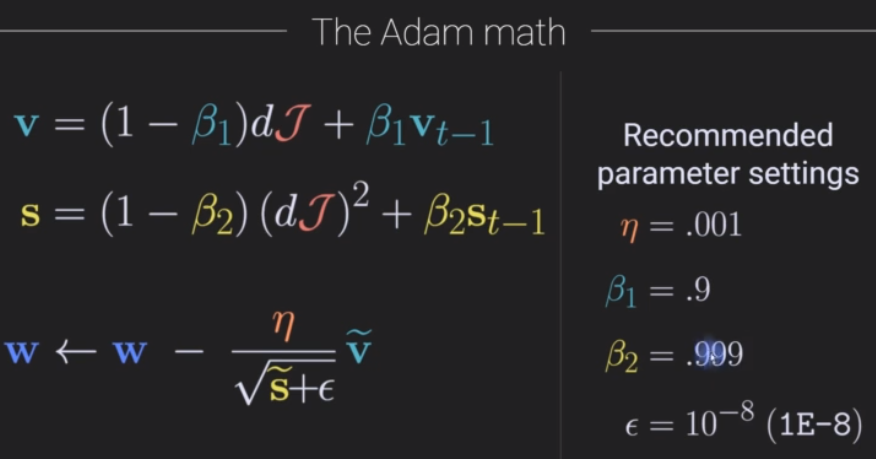

$$\tilde{v} = \frac{v}{1 - \beta^t_1}$$

$$\tilde{s} = \frac{s}{1 - \beta^t_2}$$

They are bias correction factors. In this context, $t$ is the training epoch number. In first epoch, it is $\beta^1$, in second epoch, it is $\beta^2$ and so on. This implies that we take larger steps in beginning of training, and smaller steps as we go into training.

### Optimizers comparision

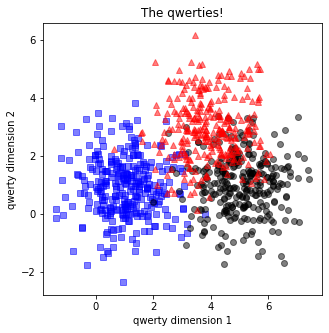

Number of batches: 50


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# create data

npc = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(npc)*blur , A[1]+np.random.randn(npc)*blur ]
b = [ B[0]+np.random.randn(npc)*blur , B[1]+np.random.randn(npc)*blur ]
c = [ C[0]+np.random.randn(npc)*blur , C[1]+np.random.randn(npc)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((npc)),
                         np.ones( (npc)),
                       1+np.ones( (npc))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

bs = 16
trainLoader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

print('Number of batches:', len(trainLoader))

# Momentum implementation in Pytorch
def createNet(optiAlg):
    
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(2, 8) # 2 ip
            self.h1 = nn.Linear(8, 8)
            self.op = nn.Linear(8, 3) # 3 op classes

        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            return self.op(x)
    
    net = qwertyNet()
    lossfn = nn.CrossEntropyLoss()
    optifun = getattr( torch.optim,optiAlg )
    optim = optifun(net.parameters(), lr = .01) # adding momentum here
    
    return net, lossfn, optim

nEp = 50

def trainModel(alg):
        
    net, lossfn, optim = createNet(alg)
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        batchAcc, batchLoss = [], []
        net.train()
        
        for X, y in trainLoader:
            op = net(X)
            loss = lossfn(op, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
        
            matches = torch.argmax(op, axis=1) == y
            matches_num = matches.float()
            accPt = 100*torch.mean(matches_num)
            batchAcc.append(accPt)
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            pred = net(x)
        testAcc.append(100*torch.mean((torch.argmax(pred, axis=1) == y).float()))
        
    return net, trainAcc, testAcc, losses

In [15]:
def plotRes(opt):
    yH = net(data)
    pred = torch.argmax(yH, axis=1)
    acc = (pred == labels).float()
    totAcc = torch.mean(100*acc).item()
    
    accByGrp = np.zeros(3)
    for i in range(3):
        accByGrp[i] = 100*torch.mean(acc[labels==i])
    
    # create the figure
    fig,ax = plt.subplots(2,2,figsize=(10,6))

    # plot the loss function
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('epoch')
    ax[0,0].set_title(f'{opt}: Losses')

    # plot the accuracy functions
    ax[0,1].plot(trainAcc,label='Train')
    ax[0,1].plot(testAcc,label='Test')
    ax[0,1].set_ylabel('Accuracy (%)')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_title(f'{opt}: Accuracy')
    ax[0,1].legend()

    # plot overall accuracy by group
    ax[1,0].bar(range(3),accByGrp)
    ax[1,0].set_ylim([np.min(accByGrp)-5,np.max(accByGrp)+5])
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')
    ax[1,0].set_ylabel('Accuracy (%)')
    ax[1,0].set_title(f'{opt}: Accuracy by group')

    # scatterplot of correct and incorrect labeled data
    colorShapes = [ 'bs','ko','g^' ] # data markers
    for i in range(3):
    # plot all data points
        ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i], alpha=.3, label=f'Group {i}')
    # cross-out the incorrect ones
        idxErr = (acc==0) & (labels==i)
        ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')

    ax[1,1].set_title(f'{opt}: Total accuracy: {totAcc:.2f}%')
    ax[1,1].set_xlabel('qwerty dimension 1')
    ax[1,1].set_ylabel('qwerty dimension 2')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

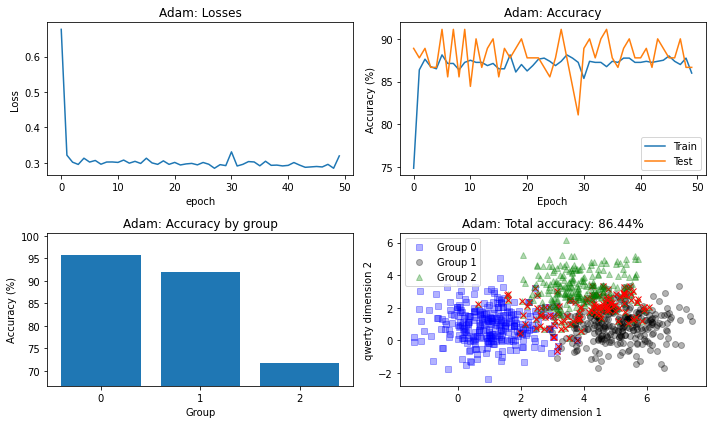

In [21]:
opt = 'Adam'
net, trainAcc, testAcc, losses = trainModel(opt)
plotRes(opt)

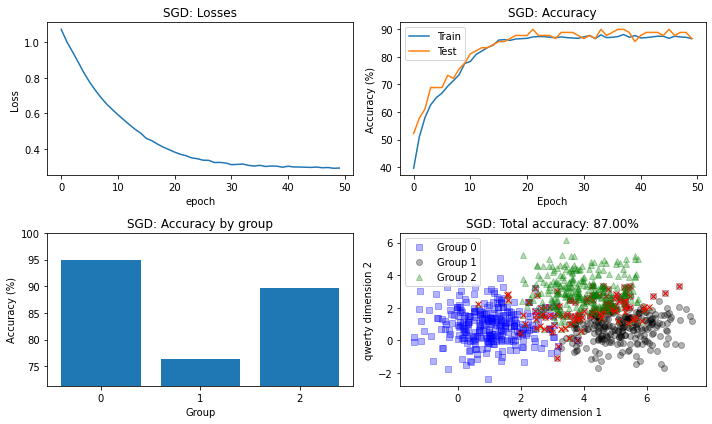

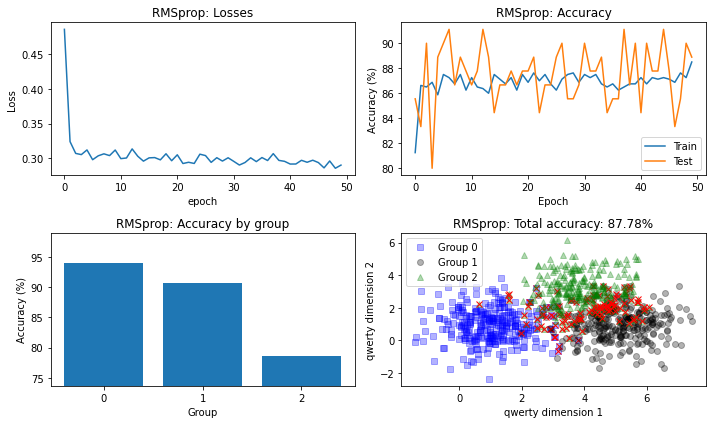

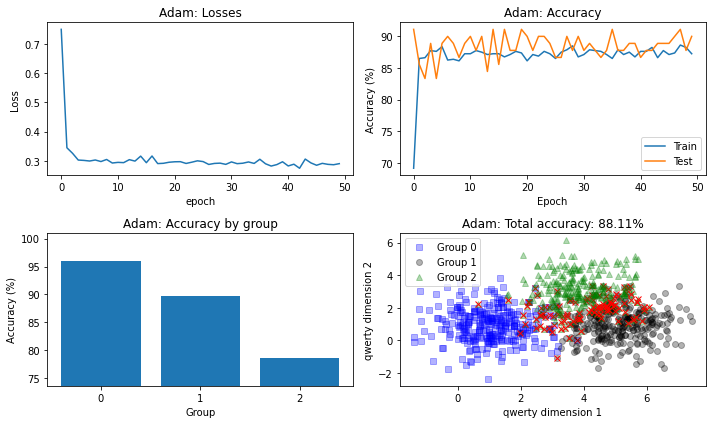

In [22]:
performance = []

for i in ['SGD', 'RMSprop', 'Adam']:
    net, trainAcc, testAcc, losses = trainModel(i)
    plotRes(i)
    
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])
    
    performance.append(f'{i}: train {train:.1f}%, test {test:.1f}%')

In [23]:
performance

['SGD: train 87.1%, test 88.4%',
 'RMSprop: train 87.3%, test 87.7%',
 'Adam: train 87.7%, test 88.8%']